# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [2]:
import geopandas as gpd
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data

Import your data, either through an API or manually, and load it. 

In [3]:
#import Data on Age Distribution in German counties from federal statistics department
dfA = pd.read_csv('dataX.csv', sep = ';')

#start cleaning by removing all rows whoch are empty
dfA.replace('-',None, inplace = True)
dfA.dropna(subset=['unter 3 Jahre'], inplace = True)
dfA.head()



,Datum,B-code,Landkreis,unter 3 Jahre,3 bis unter 6 Jahre,6 bis unter 10 Jahre,10 bis unter 15 Jahre,15 bis unter 18 Jahre,18 bis unter 20 Jahre,20 bis unter 25 Jahre,...,30 bis unter 35 Jahre,35 bis unter 40 Jahre,40 bis unter 45 Jahre,45 bis unter 50 Jahre,50 bis unter 55 Jahre,55 bis unter 60 Jahre,60 bis unter 65 Jahre,65 bis unter 75 Jahre,75 Jahre und mehr,Insgesamt
0,31.12.2021,1001,"Flensburg, kreisfreie Stadt",2709,2561,3127,3775,2284,1893,8521,...,6463,5135,4977,4855,6316,6342,5565,8861,9532,91113
1,31.12.2021,1002,"Kiel, kreisfreie Stadt",6683,6485,7895,9617,5761,4834,21478,...,20756,16442,14113,13308,16801,17553,14594,22414,24416,246243
2,31.12.2021,1003,"L�beck, kreisfreie Stadt",5371,5667,7127,8936,5508,3936,13454,...,14604,13005,12474,12300,16194,17318,14692,23374,27556,216277
3,31.12.2021,1004,"Neum�nster, kreisfreie Stadt",2135,2128,2853,3697,2298,1532,4842,...,5325,4690,4560,4571,6005,6275,5569,8583,9749,79496
4,31.12.2021,1051,"Dithmarschen, Landkreis",3241,3458,4432,5992,3758,2747,7122,...,7277,6906,7029,7536,10827,11875,10669,16993,17130,133969


In [4]:
# read the data into a DataFrame
dfA = dfA.apply(pd.to_numeric, errors = 'ignore')

#set age ranges
age_ranges = [
    ('20 bis unter 25 Jahre', '25 bis unter 30 Jahre'),
    ('30 bis unter 35 Jahre', '35 bis unter 40 Jahre'),
    ('40 bis unter 45 Jahre', '45 bis unter 50 Jahre'),
    ('50 bis unter 55 Jahre', '55 bis unter 60 Jahre')
]

#loop over the age ranges and add them together
for age_range in age_ranges:
    col1, col2 = age_range
    lower_bound = int(col1.split()[0])
    upper_bound = int(col2.split()[0])
    new_col_name = f'{lower_bound}-{upper_bound}'
    dfA[new_col_name] = dfA[col1] + dfA[col2]

# drop irrelevant age ranges
dfA.drop(['unter 3 Jahre', '3 bis unter 6 Jahre', '6 bis unter 10 Jahre', '10 bis unter 15 Jahre', '15 bis unter 18 Jahre', '18 bis unter 20 Jahre', '20 bis unter 25 Jahre', '25 bis unter 30 Jahre', '30 bis unter 35 Jahre', '35 bis unter 40 Jahre', '40 bis unter 45 Jahre', '45 bis unter 50 Jahre', '50 bis unter 55 Jahre', '55 bis unter 60 Jahre', '60 bis unter 65 Jahre'], axis=1, inplace=True)




In [5]:
#remame the columns 
dfA_final = dfA.rename(columns = {'65 bis unter 75 Jahre':'65 to under 75 years', 'Landkreis':'County', 'Datum':'Date','75 Jahre und mehr':'75 years and older', 'Insgesamt':'Total', '20-25':'20 to under 30 years', '30-35':'30 to under 40 years', '40-45':'40 to under 50 years', '50-55':'50 to under 60 years' })
#add column to construct a ratio between >65year olds in comparison to whole population
#test, will be used later -- possibly more ratios in AGE dataframe done here?
dfA_final["ratio_65+years"] = (dfA_final["65 to under 75 years"] + dfA_final["75 years and older"]) / dfA_final["Total"]



age_group =[
    ('20 to under 30 years'),
    ('30 to under 40 years'), 
    ('40 to under 50 years'), 
    ('50 to under 60 years'), 
]


for age_group in age_group:
    dfA_final[f"ratio_{age_group}"] = dfA_final[age_group] / dfA_final["Total"]

# new column order 
new_column_order = ['Date', 'B-code', 'County', '20 to under 30 years', '30 to under 40 years', '40 to under 50 years', '50 to under 60 years', '65 to under 75 years', '75 years and older','ratio_20 to under 30 years','ratio_30 to under 40 years', 'ratio_40 to under 50 years', 'ratio_50 to under 60 years', 'ratio_65+years', 'Total']
dfA_final = dfA_final.reindex(columns=new_column_order)

# display the modified DataFrame
dfA_final.head()

,Date,B-code,County,20 to under 30 years,30 to under 40 years,40 to under 50 years,50 to under 60 years,65 to under 75 years,75 years and older,ratio_20 to under 30 years,ratio_30 to under 40 years,ratio_40 to under 50 years,ratio_50 to under 60 years,ratio_65+years,Total
0,31.12.2021,1001,"Flensburg, kreisfreie Stadt",16718,11598,9832,12658,8861,9532,0.183486,0.127292,0.107910,0.138926,0.201870,91113
1,31.12.2021,1002,"Kiel, kreisfreie Stadt",44571,37198,27421,34354,22414,24416,0.181004,0.151062,0.111357,0.139513,0.190178,246243
2,31.12.2021,1003,"L�beck, kreisfreie Stadt",28215,27609,24774,33512,23374,27556,0.130458,0.127656,0.114548,0.154949,0.235485,216277
3,31.12.2021,1004,"Neum�nster, kreisfreie Stadt",9526,10015,9131,12280,8583,9749,0.119830,0.125981,0.114861,0.154473,0.230603,79496
4,31.12.2021,1051,"Dithmarschen, Landkreis",14099,14183,14565,22702,16993,17130,0.105241,0.105868,0.108719,0.169457,0.254708,133969


In [6]:


# A. Import the vehicles data set
dfK = pd.read_csv('dataY.csv', sep = ';')


# B. First Preparation of the raw data set
# Drop empty columns
dfK.drop(['Leichtkraftraeder', 'Gewoehnliche Zugmaschinen'], axis = 1, inplace=True)

# Drop empty raws
dfK.replace('-',None, inplace = True)
dfK.dropna(subset=['Kfz'], inplace = True)


# C. show data set after first manipulations
dfK


# D. create a copy of dfK for next step of manipulations
transport =dfK.copy()


# E. transform strings to numbers
transport = transport.apply(pd.to_numeric, errors = 'ignore')


# F. creating sums of existing columns
# creating Zweiraeder as sum of Kraftraeder and Motorraeder
transport['Zweiraeder'] = transport[['Kraftraeder', 'Motorraeder']].sum(axis=1)

# creating Pkw1 as sum of Pkw mit Ottomotor and Dieselmotor
transport['Pkw1'] = transport[['Pkw mit Ottomotor', 'Pkw mit Dieselmotor']].sum(axis=1)

# creating KFZ as sum of ZWeiraeder, Pkw1 and Wohnmobile 
transport['KFZ'] = transport[['Zweiraeder', 'Pkw1', 'Wohnmobile']].sum(axis=1)

# G. dropping useless columns
# Create list of columns, that we want to keep
keep_columns = ['Datum', ' B-code', ' Stadt', 'Pkw mit Ottomotor', 'Pkw mit Dieselmotor', 'Pkw1', 'Wohnmobile', 'Zweiraeder', 'KFZ'] 

# delete every other column
transport = transport.loc[:, keep_columns]


# H. rename the columns
transport.rename(columns = {'Datum':'date', ' B-code':'B-code', ' Stadt':'County', 'Pkw mit Ottomotor':'cars petrol', 'Pkw mit Dieselmotor': 'cars diesel', 'Pkw1':'cars', 'Wohnmobile':'campers', 'Zweiraeder':'two-wheelers', 'KFZ':'vehicles'}, inplace=True)


# I. creating new ratios
# create the lists for the ratios
numerator_columns = ['cars petrol', 'cars diesel', 'campers', 'two-wheelers']
denominator_columns = ['vehicles', 'vehicles', 'vehicles', 'vehicles']
 
# create the if loop to create the ratios
for i in range(len(numerator_columns)):
    ratio = transport[numerator_columns[i]] / transport[denominator_columns[i]]
    transport[numerator_columns[i] + '/' + denominator_columns[i]] = ratio


# J. show the final dataFrame
transport



,date,B-code,County,cars petrol,cars diesel,cars,campers,two-wheelers,vehicles,cars petrol/vehicles,cars diesel/vehicles,campers/vehicles,two-wheelers/vehicles
0,01.01.2022,1001,"Flensburg, kreisfreie Stadt",26809,16230,43039,1489,5826,50354,0.532411,0.322318,0.029571,0.115701
1,01.01.2022,1002,"Kiel, kreisfreie Stadt",71089,35234,106323,3650,16458,126431,0.562275,0.278682,0.028870,0.130174
2,01.01.2022,1003,"L�beck, kreisfreie Stadt",66824,30127,96951,2359,16839,116149,0.575330,0.259382,0.020310,0.144978
3,01.01.2022,1004,"Neum�nster, kreisfreie Stadt",26943,14163,41106,864,6845,48815,0.551941,0.290136,0.017699,0.140223
4,01.01.2022,1051,"Dithmarschen, Landkreis",48386,32319,80705,2184,15976,98865,0.489415,0.326900,0.022091,0.161594
...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,01.01.2022,16073,"Saalfeld-Rudolstadt, Landkreis",40236,17822,58058,613,12514,71185,0.565231,0.250362,0.008611,0.175795
472,01.01.2022,16074,Saale-Holzland-Kreis,32484,15114,47598,583,9615,57796,0.562046,0.261506,0.010087,0.166361
473,01.01.2022,16075,Saale-Orla-Kreis,32606,16411,49017,471,10073,59561,0.547439,0.275533,0.007908,0.169121
474,01.01.2022,16076,"Greiz, Landkreis",39900,18081,57981,623,11787,70391,0.566834,0.256865,0.008851,0.167450


In [7]:
#merge age and motor vehicles datasets
merged = pd.merge(dfA_final, transport, on='B-code')
merged.head()



,Date,B-code,County_x,20 to under 30 years,30 to under 40 years,40 to under 50 years,50 to under 60 years,65 to under 75 years,75 years and older,ratio_20 to under 30 years,...,cars petrol,cars diesel,cars,campers,two-wheelers,vehicles,cars petrol/vehicles,cars diesel/vehicles,campers/vehicles,two-wheelers/vehicles
0,31.12.2021,1001,"Flensburg, kreisfreie Stadt",16718,11598,9832,12658,8861,9532,0.183486,...,26809,16230,43039,1489,5826,50354,0.532411,0.322318,0.029571,0.115701
1,31.12.2021,1002,"Kiel, kreisfreie Stadt",44571,37198,27421,34354,22414,24416,0.181004,...,71089,35234,106323,3650,16458,126431,0.562275,0.278682,0.028870,0.130174
2,31.12.2021,1003,"L�beck, kreisfreie Stadt",28215,27609,24774,33512,23374,27556,0.130458,...,66824,30127,96951,2359,16839,116149,0.575330,0.259382,0.020310,0.144978
3,31.12.2021,1004,"Neum�nster, kreisfreie Stadt",9526,10015,9131,12280,8583,9749,0.119830,...,26943,14163,41106,864,6845,48815,0.551941,0.290136,0.017699,0.140223
4,31.12.2021,1051,"Dithmarschen, Landkreis",14099,14183,14565,22702,16993,17130,0.105241,...,48386,32319,80705,2184,15976,98865,0.489415,0.326900,0.022091,0.161594


## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

In [10]:
#import geodata of German constituencies to map
dfgeo = gpd.read_file("DE-counties.geojson")

#rename AGS to B-code to prepare for merging
dfgeo.rename(columns={"AGS":"B-code"}, inplace=True)

#check if it worked
print(dfgeo[["B-code"]])

    B-code
0    01001
1    01002
2    01003
3    01004
4    01051
..     ...
426  13003
427  13072
428  13073
429  13074
430  13075

[431 rows x 1 columns]


In [11]:
#merge DE counties geofile with variables

#make sure targeted variable has the same type
dfgeo['B-code']=dfgeo['B-code'].astype(int)
merged['B-code']=merged['B-code'].astype(int)

#merge the datasets
merged1 = pd.merge(merged, dfgeo, on='B-code', how="left")

#drop duplicates 
merged1.drop_duplicates(subset=['B-code'], inplace=True)

#create geodataframe to prepare for mapping
geomerged = gpd.GeoDataFrame(merged1)

In [20]:
geomerged.head()

,Date,B-code,County_x,20 to under 30 years,30 to under 40 years,40 to under 50 years,50 to under 60 years,65 to under 75 years,75 years and older,ratio_20 to under 30 years,...,NUTS,ARS_0,AGS_0,WSK,DEBKG_ID,RS,SDV_RS,RS_0,geometry,ratio_Wohnmobile
0,31.12.2021,1001,"Flensburg, kreisfreie Stadt",16718,11598,9832,12658,8861,9532,0.183486,...,DEF01,010010000000,01001000,2008-01-01,DEBKGDL20000002R,01001,010010000000,010010000000,"POLYGON ((9.41266 54.82264, 9.42293 54.82322, ...",0.016342
2,31.12.2021,1002,"Kiel, kreisfreie Stadt",44571,37198,27421,34354,22414,24416,0.181004,...,DEF02,010020000000,01002000,2006-01-01,DEBKGDL20000E43X,01002,010020000000,010020000000,"POLYGON ((10.16916 54.43138, 10.18877 54.41108...",0.014823
4,31.12.2021,1003,"L�beck, kreisfreie Stadt",28215,27609,24774,33512,23374,27556,0.130458,...,DEF03,010030000000,01003000,2006-02-01,DEBKGDL20000DYM9,01003,010030000000,010030000000,"POLYGON ((10.87684 53.98737, 10.88454 53.97820...",0.010907
5,31.12.2021,1004,"Neum�nster, kreisfreie Stadt",9526,10015,9131,12280,8583,9749,0.119830,...,DEF04,010040000000,01004000,1970-04-26,DEBKGDL20000E4KX,01004,010040000000,010040000000,"POLYGON ((9.99545 54.14972, 10.00821 54.14217,...",0.010868
6,31.12.2021,1051,"Dithmarschen, Landkreis",14099,14183,14565,22702,16993,17130,0.105241,...,DEF05,010510000000,01051000,2011-08-01,DEBKGDL20000E14G,01051,010510044044,010510000000,"MULTIPOLYGON (((9.07777 54.36249, 9.09085 54.3...",0.016302


cars petrol/vehicles


AttributeError: 'DataFrame' object has no attribute 'crs'

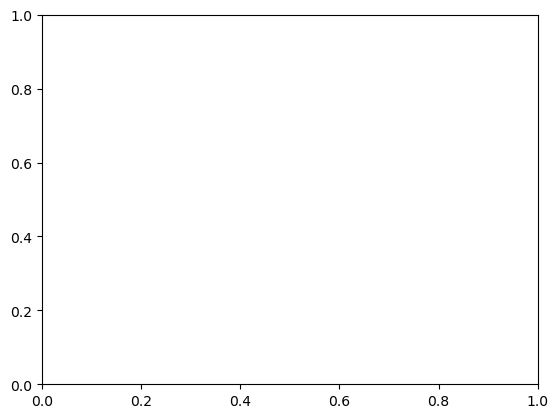

In [36]:
#graph ratios manually

#shoutout to https://github.com/jgehrcke/covid-19-germany-gae

#for example, the ratio of cars using petrol engines to the total number of cars has the following
#distribution on a map of Germany
dataproject.ratio = "cars petrol/vehicles"

print(dataproject.ratio)

dataproject.plot(True)

dataproject.ratio = "cars diesel/vehicles"

dataproject.plot(True)

In [37]:
#interactive graph for different age distribution

#set columns to ratios of ages
dataproject.min1 = 9
dataproject.max1 = 13

dataproject.dfK_new1 = transport 

dataproject.merged2 = merged1

dataproject.interactive_plot1(True)

interactive(children=(IntSlider(value=9, description='Column:', max=13, min=9), Output()), _dom_classes=('widg…

In [38]:
#vehicle ratios

dataproject.min1 = 23
dataproject.max1 = 26

dataproject.dfK_new1 = transport 

dataproject.merged2 = merged1

dataproject.interactive_plot1(True)

interactive(children=(IntSlider(value=23, description='Column:', max=26, min=23), Output()), _dom_classes=('wi…

In [ ]:
#ratios between ages and vehicles
#what could be interesting

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

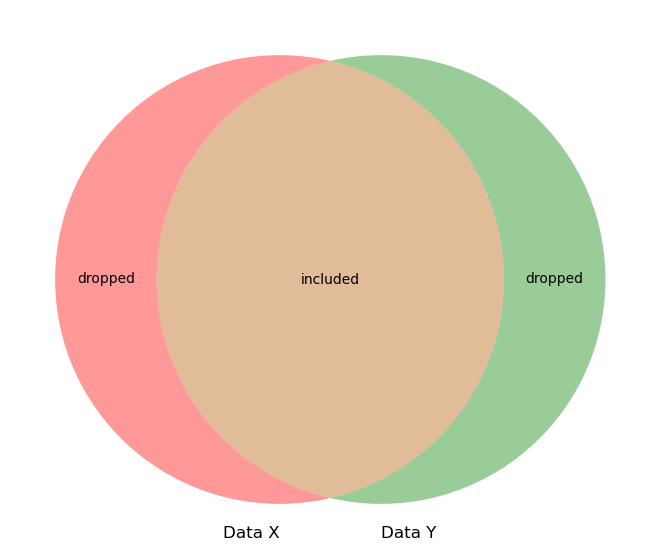

In [ ]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.